In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# %cd "/content/drive/My Drive/Colab Notebooks/w266_final/"

/content/drive/.shortcut-targets-by-id/1I3W7Z7rz_YfsjBjX7z4zTzGbr-iKTrmD/w266_final


# I2b2 dataset
Contents of the 2018 Task2 challenge:  
This dataset was created to identify Adverse Drug Events and Medication Extraction in EHRs. This challenge focused on three tasks:
- Identifying concepts: drug names, dosages, durations, etc.  
- Identifying relations: relation of drugs with ADE's and other entities given gold standard entities (generated by human annotators). 
- Running an end-to-end model that identifies relation of drugs with ADE's and other entittes on system predicted entitites.  

See documentation for more details.  

The training data is composed of individual notes (.txt extension) and corresponding individual annotation files (.ann extension).   
Annotation files contain tags (labeled with a leading 'T') and relations (labeled with a leading 'R'):
- For tags, the structure is: Tag_id, Tag_entity, Start_character_loc, End_character_loc  
- For relations, the structure is: Relation_id, Relation_entity, Arg1:Tag_id, Arg2:Tag_id  

In [1]:
import pandas as pd
import i2b2_evaluate as i2b2e
import glob, os
import sys, io
import re
import matplotlib.pyplot as plt
import numpy as np
import nltk
import statistics as stats
import itertools
from nltk.tokenize import sent_tokenize 
from pathlib import Path, PureWindowsPath, PurePosixPath

%matplotlib inline

In [2]:
#test_path = '/Users/valeriemeausoone/Documents/W266/github_repo/w266_final/data/i2b2/2018/training_20180910/training_20180910/100035.ann'
# file_path = '/Users/valeriemeausoone/Documents/W266/github_repo/w266_final/data/i2b2/2018/training_20180910/training_20180910/'
file_path ='data/i2b2/2018/training_20180910/training_20180910/'
# os.chdir(file_path)
data_folder = Path(file_path)
# list(data_folder.glob('**/*.txt'))

    

# Processing training data for BERT

## Sentence tokenizing

In [3]:
list_text_files = list(data_folder.glob('**/*.txt'))
list_ann_files = list(data_folder.glob('**/*.ann'))

text_directory = sorted(list_text_files)
ann_directory = sorted(list_ann_files)
                                        
list_files=[]
for file in text_directory:
    with open(file, 'rb') as f:
        text=f.read().decode("utf-8")
        list_files.append(text)

In [4]:
print(text_directory[0:10])
print(ann_directory[0:10])
print(len(list_files))

[WindowsPath('data/i2b2/2018/training_20180910/training_20180910/100035.txt'), WindowsPath('data/i2b2/2018/training_20180910/training_20180910/100039.txt'), WindowsPath('data/i2b2/2018/training_20180910/training_20180910/100187.txt'), WindowsPath('data/i2b2/2018/training_20180910/training_20180910/100229.txt'), WindowsPath('data/i2b2/2018/training_20180910/training_20180910/100564.txt'), WindowsPath('data/i2b2/2018/training_20180910/training_20180910/100579.txt'), WindowsPath('data/i2b2/2018/training_20180910/training_20180910/100590.txt'), WindowsPath('data/i2b2/2018/training_20180910/training_20180910/100677.txt'), WindowsPath('data/i2b2/2018/training_20180910/training_20180910/100847.txt'), WindowsPath('data/i2b2/2018/training_20180910/training_20180910/100883.txt')]
[WindowsPath('data/i2b2/2018/training_20180910/training_20180910/100035.ann'), WindowsPath('data/i2b2/2018/training_20180910/training_20180910/100039.ann'), WindowsPath('data/i2b2/2018/training_20180910/training_2018091

In [5]:
def sentence_tokenization(text):
    '''Splitting discharge summaries into sentences. Because discharge summaries are not consistently organized,
    extra processing is done to clean-up sentences and phrases. Chunks of texts are kept together to avoid splitting
    phrases too granularly'''
    #Using NLTK's sent_tokenize 
    sentence_tokens = sent_tokenize(text) 
    
    #Splititng paragraphs
    sentence_tokens2 = [paragraph for sentence in sentence_tokens for paragraph in sentence.split("\n\n\n")]
        
    #Removing sentences that are too short: only one dot (.) or a numerical bullet point (1., 2., 3.., ...10., etc.)    
    sentence_tokens3 = [sentence.strip() for sentence in sentence_tokens2 if (sentence != ".") or (re.match(r'\d*\.', sentence) is None)]

    #Cleaning up line breaks and replacing them with empty spaces
    sentence_tokens_clean = [sentence.replace('\n', ' ') for sentence in sentence_tokens3]
    
    #Saving results as dataframe 
    #sentences = pd.DataFrame(sentence_tokens_clean)
    #sentences = sentences.rename(columns={0:"sentences"})
    
    return sentence_tokens_clean

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pnars\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
#100035.txt and 100039.txt
for file in list_files[0:2]:
    print(sentence_tokenization(file)[0])
    sentences = sentence_tokenization(file)

 x2.an OSH with dyspnea now admitted to the MICU after PEA arrestPMH signifciant
 vomitting of unclear etiology.ere from [**Date range (1) **] with nausea and*]


## Linking with relations

In [8]:
def annotations_processing(file):
    '''This function processes the annotation files into dataframes (relation and concept). 
    It then combines these dataframes to create an enhanced relations dictionary'''
    
    #Reading the annotation file into a combined dataframe. 
    ann_df = pd.read_csv(file, sep="\t", header=None)
    ann_df = ann_df.rename(columns={0:"tag", 1:"description", 2:"text"})

    #Splitting concept entities and relations
    #Relations dataframe
    null_entries = pd.isnull(ann_df["text"])
    rf_df = ann_df[null_entries]
    rf_df = rf_df.rename(columns={'tag':"relation_id", 'description':"relation_description", 'text': 'relation_text'})
    
    #Cleaning up

    rf_df[['relation','arg1', 'arg2']] = rf_df['relation_description'].str.split(' ',expand=True)
    rf_df[['arg1_delete','arg1_keep']] = rf_df['arg1'].str.split(':',expand=True)
    rf_df[['arg2_delete','arg2_keep']] = rf_df['arg2'].str.split(':',expand=True)
    rf_df = rf_df.drop(columns=['relation_text', 'arg1', 'arg2', 'arg1_delete', 'arg2_delete'])
    rf_df = rf_df.rename(columns={'arg1_keep':"arg1", 'arg2_keep':"arg2"})
    
    
    #Concepts dataframe
    entries = pd.notnull(ann_df["text"])
    tag_df = ann_df[entries]
    tag_df = tag_df.rename(columns={'tag':"concept_id", 'description':"concept_description", 'text': 'concept_text'})

    #Combining relations and tags dataframes to create an enhanced relations dataframe
    rf_df = pd.merge(rf_df, tag_df, left_on = 'arg1', right_on='concept_id')
    rf_df = rf_df.rename(columns={'concept_id': 'arg1_id', 'concept_description':"arg1_description", 'concept_text':"arg1_text"})
    rf_df = pd.merge(rf_df, tag_df, left_on = 'arg2', right_on='concept_id')
    rf_df = rf_df.rename(columns={'concept_id': 'arg2_id', 'concept_description':"arg2_description", 'concept_text':"arg2_text"})
    rf_df = rf_df.drop(columns=['arg1_id', 'arg2_id'])

    #Creating a relations dictionary
    #Note that there could be "duplicate" relations that we will have to re-identify later. 
    dict_relation = {}
    for sentence in sentences: 
        for i in range(len(rf_df)):
            arg1 = rf_df['arg1_text'][i]
            arg2 = rf_df['arg2_text'][i]
            relation = rf_df['relation'][i]
            dict_relation[(arg1, arg2)] = relation
    return dict_relation

In [9]:
list_relations = [annotations_processing(file) for file in ann_directory]
len(list_relations)

303

## Compiling the dataframe

In [10]:
file_num=0
relation_sentences=[]
errors= 0
for file in list_files:
    
    #implementing sentence tokenization
    sentences = np.array(sentence_tokenization(file))

    #listing entities that make up relations
    list_entities = list(list_relations[file_num].keys())
    
    #looking for relation tags in sentences and pulling out sentences. 
    for e in list_entities:        
        new_e = e
        arg1_indices = np.where(np.char.find(sentences, new_e[0])>=0)[0]
        if arg1_indices.size==0: 
            new_e = list(new_e)
            new_e[0] = new_e[0].replace(' ', '')
            new_e = tuple(new_e)
            arg1_indices = np.where(np.char.find(sentences, new_e[0])>=0)[0]

        arg2_indices = np.where(np.char.find(sentences, new_e[1])>=0)[0]
        if arg2_indices.size==0: 
            new_e = list(new_e)
            new_e[1] = new_e[1].replace(' ', '')
            new_e = tuple(new_e)
            arg2_indices = np.where(np.char.find(sentences, new_e[1])>=0)[0]

        #extract where minimum. 
        combinations = [(i,j,abs(i-j)) for i,j in list(itertools.product(arg1_indices, arg2_indices))]
        try:
            min_distance = min(combinations, key = lambda t: t[2])[2]
        except ValueError:
            min_distance = "none"
        if min_distance != "none":
            min_combinations = [(t[0], t[1]) for t in combinations if t[2] == min_distance]
            for c in min_combinations:
                if c[0]==c[1]:
                    include_sentence = sentences[c[0]]
                    include_sentence = include_sentence.replace(new_e[0], ("SUB_B " + new_e[0] + " SUB_E"))
                    include_sentence = include_sentence.replace(new_e[1], ("OBJ_B " + new_e[1] + " OBJ_E"))
                    relation_sentences.append((new_e, list_relations[file_num][e], include_sentence))
                    sentences.tolist().pop(c[0])
                elif c[0]!=c[1]:
                    include_sentence = sentences[c[0]] + " " + sentences[c[1]]
                    include_sentence = include_sentence.replace(new_e[0], ("SUB_B " + new_e[0] + " SUB_E"))
                    include_sentence = include_sentence.replace(new_e[1], ("OBJ_B " + new_e[1] + " OBJ_E"))
                    relation_sentences.append((new_e, list_relations[file_num][e], include_sentence))
                    sentences.tolist().pop(c[0])
                    sentences.tolist().pop(c[1])
                    
    for s in range(len(sentences)):
        relation_sentences.append(("none", "no relation", sentences[s]))   
    #print("output length", len(relation_sentences))
    
    file_num+=1

In [11]:
print("Number of sentences", len(relation_sentences))

Number of sentences 73664


In [12]:
#Generating a dataframe
train_df = pd.DataFrame(relation_sentences)
train_df = train_df.rename(columns={0:"args", 1:"relation", 2: "sentence"})
train_df.head()

,args,relation,sentence
0,"(recurrent seizures, ativan)",Reason-Drug,He also may have\r SUB_B recurrent seizures SU...
1,"(IM, ativan)",Route-Drug,He also may have\r recurrent seizures which sh...
2,"(IV, ativan)",Route-Drug,He also may have\r recurrent seizures which sh...
3,"(25mg, Topiramate)",Strength-Drug,-patient will be on OBJ_B Topiramate OBJ_E SUB...
4,"(PO, Topiramate)",Route-Drug,-patient will be on OBJ_B Topiramate OBJ_E 25m...


In [13]:
train_df['relation'].value_counts()

no relation       39641
Strength-Drug      6741
Route-Drug         5928
Frequency-Drug     5700
Reason-Drug        4960
Form-Drug          4621
Dosage-Drug        4389
ADE-Drug           1081
Duration-Drug       603
Name: relation, dtype: int64

In [14]:
train_df['relation'].unique()

array(['Reason-Drug', 'Route-Drug', 'Strength-Drug', 'Frequency-Drug',
       'Duration-Drug', 'Form-Drug', 'Dosage-Drug', 'ADE-Drug',
       'no relation'], dtype=object)

In [15]:
print("Percentage without a relation:", 40955*100/len(train_df))

Percentage without a relation: 55.597035186794095


In [16]:
label_list = train_df['relation'].unique()

label_to_ids_map =  {label: i for i, label in enumerate(label_list)}

print(label_to_ids_map)

{'Reason-Drug': 0, 'Route-Drug': 1, 'Strength-Drug': 2, 'Frequency-Drug': 3, 'Duration-Drug': 4, 'Form-Drug': 5, 'Dosage-Drug': 6, 'ADE-Drug': 7, 'no relation': 8}


In [17]:
def to_label_id(series):
    return label_to_ids_map[series]

train_df_bert = train_df.copy()
train_df_bert = pd.DataFrame({
    'id':range(len(train_df)),
    'label': train_df['relation'].apply(to_label_id),
    'alpha':['a']*train_df.shape[0],
    'text': train_df['sentence']
})

In [18]:
train_df_bert.head()

,id,label,alpha,text
0,0,0,a,He also may have\r SUB_B recurrent seizures SU...
1,1,1,a,He also may have\r recurrent seizures which sh...
2,2,1,a,He also may have\r recurrent seizures which sh...
3,3,2,a,-patient will be on OBJ_B Topiramate OBJ_E SUB...
4,4,1,a,-patient will be on OBJ_B Topiramate OBJ_E 25m...


In [19]:
train_df_bert.to_csv("i2b2_train_bert.csv",  sep='\t', index=False, header=False)

In [22]:
train_df_bert.to_csv("data/train.tsv", sep = '\t', index=False, header=False)

# Processting test data for BERT

In [23]:
#test_path = '/Users/valeriemeausoone/Documents/W266/github_repo/w266_final/data/i2b2/2018/training_20180910/training_20180910/100035.ann'
# file_path = '/Users/valeriemeausoone/Documents/W266/github_repo/w266_final/data/i2b2/2018/gold_standard_test/'
# os.chdir(file_path)
file_path ='data/i2b2/2018/gold_standard_test/'
# os.chdir(file_path)
data_folder = Path(file_path)

## Sentence Tokenizing

In [24]:
# text_directory = sorted(glob.glob("*.txt"))
# ann_directory = sorted(glob.glob("*.ann"))
list_text_files = list(data_folder.glob('**/*.txt'))
list_ann_files = list(data_folder.glob('**/*.ann'))

text_directory = sorted(list_text_files)
ann_directory = sorted(list_ann_files)

list_files=[]
for file in text_directory:
    with open(file, 'rb') as f:
        text=f.read().decode("utf-8")
        list_files.append(text)

In [25]:
list_relations = [annotations_processing(file) for file in ann_directory]
len(list_relations)

201

In [26]:
file_num=0
relation_sentences=[]
errors= 0
for file in list_files:
    
    #implementing sentence tokenization
    sentences = np.array(sentence_tokenization(file))

    #listing entities that make up relations
    list_entities = list(list_relations[file_num].keys())
    
    #looking for relation tags in sentences and pulling out sentences. 
    for e in list_entities:        
        new_e = e
        arg1_indices = np.where(np.char.find(sentences, new_e[0])>=0)[0]
        if arg1_indices.size==0: 
            new_e = list(new_e)
            new_e[0] = new_e[0].replace(' ', '')
            new_e = tuple(new_e)
            arg1_indices = np.where(np.char.find(sentences, new_e[0])>=0)[0]

        arg2_indices = np.where(np.char.find(sentences, new_e[1])>=0)[0]
        if arg2_indices.size==0: 
            new_e = list(new_e)
            new_e[1] = new_e[1].replace(' ', '')
            new_e = tuple(new_e)
            arg2_indices = np.where(np.char.find(sentences, new_e[1])>=0)[0]

        #extract where minimum. 
        combinations = [(i,j,abs(i-j)) for i,j in list(itertools.product(arg1_indices, arg2_indices))]
        try:
            min_distance = min(combinations, key = lambda t: t[2])[2]
        except ValueError:
            min_distance = "none"
        if min_distance != "none":
            min_combinations = [(t[0], t[1]) for t in combinations if t[2] == min_distance]
            for c in min_combinations:
                if c[0]==c[1]:
                    include_sentence = sentences[c[0]]
                    include_sentence = include_sentence.replace(new_e[0], ("SUB_B " + new_e[0] + " SUB_E"))
                    include_sentence = include_sentence.replace(new_e[1], ("OBJ_B " + new_e[1] + " OBJ_E"))
                    relation_sentences.append((new_e, list_relations[file_num][e], include_sentence))
                    sentences.tolist().pop(c[0])
                elif c[0]!=c[1]:
                    include_sentence = sentences[c[0]] + " " + sentences[c[1]]
                    include_sentence = include_sentence.replace(new_e[0], ("SUB_B " + new_e[0] + " SUB_E"))
                    include_sentence = include_sentence.replace(new_e[1], ("OBJ_B " + new_e[1] + " OBJ_E"))
                    relation_sentences.append((new_e, list_relations[file_num][e], include_sentence))
                    sentences.tolist().pop(c[0])
                    sentences.tolist().pop(c[1])
                    
    for s in range(len(sentences)):
        relation_sentences.append(("none", "no relation", sentences[s]))   
    #print("output length", len(relation_sentences))
    
    file_num+=1
    
print("Number of sentences", len(relation_sentences))

Number of sentences 48250


In [27]:
#Generating a dataframe
test_df = pd.DataFrame(relation_sentences)
test_df = test_df.rename(columns={0:"args", 1:"relation", 2: "sentence"})

test_df['relation'].value_counts()

no relation       26596
Strength-Drug      4255
Route-Drug         3707
Frequency-Drug     3574
Reason-Drug        3228
Form-Drug          3008
Dosage-Drug        2768
ADE-Drug            723
Duration-Drug       391
Name: relation, dtype: int64

In [28]:
test_df.head()

,args,relation,sentence
0,"(q.i.d, Decadron)",Frequency-Drug,"MEDICATIONS: Lipitor, Tylenol with Codeine, D..."
1,"(one week, Decadron)",Duration-Drug,tapered over SUB_B one week SUB_E and\r discon...
2,"(q.1 hour, Pred Forte)",Frequency-Drug,The patient's course in the Intensive Care Uni...
3,"(eye, Pred Forte)",Route-Drug,The patient's course in the Intensive Care Uni...
4,"(decrease insensible losses, Vaseline hydrated...",Reason-Drug,"With regard to her skin lesions, they\r contin..."


In [29]:
print("Percentage without a relation:", 27438*100/len(test_df))

Percentage without a relation: 56.866321243523316


In [30]:
label_list = test_df['relation'].unique()

### DO NOT RERUN THIS _ IT IS WRONG. Use from the training data instead!!!!
##label_to_ids_map =  {label: i for i, label in enumerate(label_list)}
print(label_to_ids_map)

{'Reason-Drug': 0, 'Route-Drug': 1, 'Strength-Drug': 2, 'Frequency-Drug': 3, 'Duration-Drug': 4, 'Form-Drug': 5, 'Dosage-Drug': 6, 'ADE-Drug': 7, 'no relation': 8}


In [31]:


def to_label_id(series):
    return label_to_ids_map[series]

test_df_bert = test_df.copy()
test_df_bert = pd.DataFrame({
    'id':range(len(test_df)),
    'label': test_df['relation'].apply(to_label_id),
    'alpha':['a']*test_df.shape[0],
    'text': test_df['sentence']
})

test_df_bert.head()

,id,label,alpha,text
0,0,3,a,"MEDICATIONS: Lipitor, Tylenol with Codeine, D..."
1,1,4,a,tapered over SUB_B one week SUB_E and\r discon...
2,2,3,a,The patient's course in the Intensive Care Uni...
3,3,1,a,The patient's course in the Intensive Care Uni...
4,4,0,a,"With regard to her skin lesions, they\r contin..."


In [32]:
test_df_bert.to_csv("i2b2_test_bert.csv",  index=False, header=False)

In [81]:
# !pwd

In [35]:
test_df_bert.to_csv("data/dev.tsv", sep = '\t', index=False, header=False)

# Exploring the prepared data

In [36]:
# %cd "/content/drive/My Drive/Colab Notebooks/w266_final/project_re"

[WinError 3] The system cannot find the path specified: '/content/drive/My Drive/Colab Notebooks/w266_final/project_re'
C:\prabhu\edu\code\w266\project_submission


In [37]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

<ipython-input-37-fd0b9af24538>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [82]:
# !head -5 'data_divided/train.tsv'

In [39]:
#ADE-Drug: 7
#Reason-Drug: 0

In [48]:
train_df = pd.read_csv("data_divided/train.tsv", sep = "\t", header=None)
train_df = train_df.rename(columns={0: "id", 1: "relation_code", 2: "alpha", 3:"string"})

In [49]:
train_df.head()

,id,relation_code,alpha,string
0,0,0,a,He also may have SUB_B recurrent seizures SUB_E which should be treated with OBJ_B ativan OBJ_E IV or IM and do not neccessarily indicate patient needs to return to hospital unless they continue for greater than 5 minutes or he has multiple SUB_B recurrent seizures SUB_E or complications such as aspiration.
1,1,1,a,He also may have recurrent seizures which should be treated with OBJ_B ativan OBJ_E IV or SUB_B IM SUB_E and do not neccessarily indicate patient needs to return to hospital unless they continue for greater than 5 minutes or he has multiple recurrent seizures or complications such as aspiration.
2,2,1,a,He also may have recurrent seizures which should be treated with OBJ_B ativan OBJ_E SUB_B IV SUB_E or IM and do not neccessarily indicate patient needs to return to hospital unless they continue for greater than 5 minutes or he has multiple recurrent seizures or complications such as aspiration.
3,3,2,a,-patient will be on OBJ_B Topiramate OBJ_E SUB_B 25mg SUB_E PO BID until [**3-22**] PM then increase to 50mg po BID for seven days then increase to 75mg [**Hospital1 **] ongoing.
4,4,1,a,-patient will be on OBJ_B Topiramate OBJ_E 25mg SUB_B PO SUB_E BID until [**3-22**] PM then increase to 50mg po BID for seven days then increase to 75mg [**Hospital1 **] ongoing.


In [50]:
train_df.dtypes

id               int64 
relation_code    int64 
alpha            object
string           object
dtype: object

In [51]:
train_df['string'] = train_df['string'].apply(str)

In [52]:
train_df.dtypes

id               int64 
relation_code    int64 
alpha            object
string           object
dtype: object

In [53]:
train_df['relation_code'].value_counts()

8    427
2    97 
3    96 
1    95 
0    91 
5    84 
6    75 
7    19 
4    16 
Name: relation_code, dtype: int64

## Sentence length by type of relation

In [54]:
train_df['seq_len'] = train_df['string'].apply(len)

In [55]:
# dev_df['string'] = dev_df['string'].apply(str)
# dev_df['seq_len'] = dev_df['string'].apply(len)

In [56]:
test_df.head()

,args,relation,sentence
0,"(q.i.d, Decadron)",Frequency-Drug,"MEDICATIONS: Lipitor, Tylenol with Codeine, Dilantin,\r previously on OBJ_B Decadron OBJ_E SUB_B q.i.d SUB_E."
1,"(one week, Decadron)",Duration-Drug,"tapered over SUB_B one week SUB_E and\r discontinued a week ago. MEDICATIONS: Lipitor, Tylenol with Codeine, Dilantin,\r previously on OBJ_B Decadron OBJ_E q.i.d."
2,"(q.1 hour, Pred Forte)",Frequency-Drug,"The patient's course in the Intensive Care Unit was\r uneventful, and she was discharged to the floor with very\r close monitoring which included SUB_B q.1 hour SUB_E OBJ_B Pred Forte OBJ_E\r application to the eye and close consultation with\r Ophthalmology."
3,"(eye, Pred Forte)",Route-Drug,"The patient's course in the Intensive Care Unit was\r uneventful, and she was discharged to the floor with very\r close monitoring which included q.1 hour OBJ_B Pred Forte OBJ_E\r application to the SUB_B eye SUB_E and close consultation with\r Ophthalmology."
4,"(decrease insensible losses, Vaseline hydrated petroleum)",Reason-Drug,"With regard to her skin lesions, they\r continued exfoliate over the next couple of days, and her\r skin care included frequent OBJ_B Vaseline hydrated petroleum OBJ_E\r application to SUB_B decrease insensible losses SUB_E."


In [57]:
test_df = pd.read_csv("data_divided/test.tsv", sep = "\t", header=None)
test_df = test_df.rename(columns={0: "id", 1: "relation_code", 2: "alpha", 3:"string"})
test_df['string'] = test_df['string'].apply(str)
test_df['seq_len'] = test_df['string'].apply(len)
#test_df = test_df.rename(columns={'sentence':'string'}, inplace=True)

In [58]:
len(test_df)

1000

In [59]:
len(train_df)

1000

In [63]:
# all_df = train_df.append(dev_df)
all_df = train_df.append(test_df)

In [64]:
len(all_df)

2000

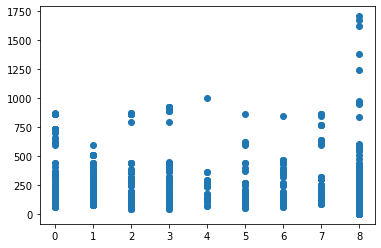

In [65]:
import matplotlib.pyplot as plt
plt.scatter(all_df['relation_code'], all_df['seq_len'])
plt.show()

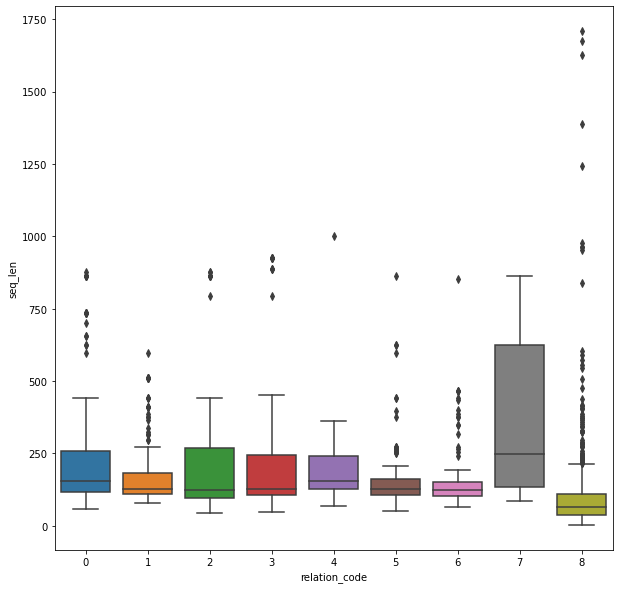

In [66]:
import seaborn as sns
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1 = sns.boxplot(x = 'relation_code', y = 'seq_len' , data = all_df)

In [67]:
all_df.seq_len.mean()

144.344

In [68]:
all_df.seq_len.min()

2

In [69]:
all_df.seq_len.max()

1709

In [70]:
all_df.columns

Index(['id', 'relation_code', 'alpha', 'string', 'seq_len'], dtype='object')

In [71]:
all_df.groupby('relation_code').mean()

,id,seq_len
relation_code,,
0,538.703704,249.777778
1,551.831081,178.756757
2,612.870748,204.340136
3,597.139073,211.596026
4,326.692308,211.230769
5,636.808511,156.567376
6,612.685950,158.446281
7,568.000000,343.826923
8,538.819277,94.443003


In [72]:
all_df[all_df['relation_code']==7].string.str.count("treat").sum()

12

In [73]:
all_df[all_df['relation_code']==0].string.str.count("treat").sum()

15

In [74]:
#Reason-Drug
reason_df = train_df[train_df['relation_code'] == 0]
reason_df.iloc[0:10,:]

,id,relation_code,alpha,string,seq_len
0,0,0,a,He also may have SUB_B recurrent seizures SUB_E which should be treated with OBJ_B ativan OBJ_E IV or IM and do not neccessarily indicate patient needs to return to hospital unless they continue for greater than 5 minutes or he has multiple SUB_B recurrent seizures SUB_E or complications such as aspiration.,308
14,14,0,a,His extubation was initially limited both by SUB_B agitation SUB_E requiring OBJ_B sedation OBJ_E and by requirements for high PEEP to maintain oxygenation.,156
15,15,0,a,His oxygenation was improved with diuresis and SUB_B agitation SUB_E was better controlled with OBJ_B seroquel OBJ_E.,117
17,19,0,a,"His SUB_B Asthma SUB_E was treated with standing and PRN albuterol and OBJ_B ipratriopium OBJ_E and a slow prednisone taper which he l completed on [**2115-3-18**] and he was restarted on Advair -patient may require additional nebs on top of his standing advair though his respiratory status has been very stable, without wheezing for the last week.",349
21,24,0,a,"His SUB_B Asthma SUB_E was treated with standing and PRN albuterol and ipratriopium and a slow prednisone taper which he l completed on [**2115-3-18**] and he was restarted on OBJ_B Advair OBJ_E -patient may require additional nebs on top of his standing advair though his respiratory status has been very stable, without wheezing for the last week.",349
23,26,0,a,"His Asthma was treated with standing and PRN albuterol and ipratriopium and a slow prednisone taper which he l completed on [**2115-3-18**] and he was restarted on Advair -patient may require additional nebs on top of his standing OBJ_B advair OBJ_E though his respiratory status has been very stable, without SUB_B wheezing SUB_E for the last week.",349
24,28,0,a,"He received vecuronium and was started on an OBJ_B epi OBJ_E gtt for SUB_B asthma SUB_E and a cooling protocol, and was then transferred to [**Hospital1 18**] for further evaluation.",182
25,29,0,a,# SUB_B Ventilator associated pneumonia SUB_E: Patient developed a fever on [**2-27**] with new infiltrates on chest xray while intubated. He was initially covered with OBJ_B vanc OBJ_E/cefepime and cipro.,206
26,30,0,a,# SUB_B Ventilator associated pneumonia SUB_E: Patient developed a fever on [**2-27**] with new infiltrates on chest xray while intubated. He was initially covered with vanc/OBJ_B cefepime OBJ_E and cipro.,206
35,42,0,a,Also continued on home dose of carvedilol and Lisinopril but OBJ_B ACE OBJ_E downtitrated from 40 to 20 when had SUB_B elevated Cr 1.9 SUB_E on [**3-18**] and slightly low BPs high 90s/60s.,189


In [75]:
#ADE-Drug
ade_df = train_df[train_df['relation_code'] == 7]
ade_df.iloc[0:10,:]

,id,relation_code,alpha,string,seq_len
46,57,7,a,Since no new infection was found this was presumed [**12-26**] steroids and the SUB_B leukocytosis SUB_E improved with OBJ_B prednisone OBJ_E taper.,148
47,58,7,a,"# SUB_B Hyperglycemia SUB_E: Patient is not known to be a diabetic and was felt [**12-26**] OBJ_B steroids OBJ_E, his sugars were controlled on sliding scale insulin in the hospital but he no longer had insulin requirements as his prednisone was tapered.",255
328,408,7,a,"Brief Hospital Course: 38 yo F w/ h/o ALL in remission s/p cord transplant in [**1-13**], OBJ_B anthracycline OBJ_E-induced SUB_B cardiomyopathy SUB_E (EF 15-20% [**1-14**]) and recurrent nausea and vomiting who presents with 1 week abd pain, acute on chronic renal failure and new hyperbilirubinemia.",301
330,410,7,a,# OBJ_B Anthracycline OBJ_E-induced/ GVHD SUB_B cardiomyopathy SUB_E: EF <20% on echo from 2/[**2174**].,105
347,433,7,a,"Renal saw the patient who thought this was likely from SUB_B overdiuresis SUB_E (home OBJ_B torsemide OBJ_E regimen of 20mg [**Hospital1 **]) in conjunction with her [**Last Name (LF) **], [**First Name3 (LF) **] recommended holding diuresis.",242
715,888,7,a,"# SUB_B Abdominal wall hematoma SUB_E: As mentioned above, she developed a large left-sided abdominal wall hematoma from a OBJ_B Lovenox OBJ_E injection site that caused a significant hct drop (originally 28.1-->19.4).",218
727,900,7,a,"Brief Hospital Course: 64F w/ h/o recurrent PE s/[**Initials (NamePattern4) **] [**Last Name (NamePattern4) 260**] filter, GIB on OBJ_B anticoagulation OBJ_E, COPD, recently admitted for new PE, readmitted for multifocal PNA, who developed a large abdominal wall SUB_B hematoma SUB_E in the context of enoxaparin injections.",324
728,901,7,a,"It was decided after her second SUB_B hematoma SUB_E while on OBJ_B anticoagulation OBJ_E, the risks of OBJ_B anticoagulation OBJ_E outweigh the benefits at this time and she was not anticoagulated.",198
729,902,7,a,"It was decided after her second SUB_B hematoma SUB_E while on OBJ_B anticoagulation OBJ_E, the risks of OBJ_B anticoagulation OBJ_E outweigh the benefits at this time and she was not anticoagulated.",198
730,903,7,a,"Discharge Disposition: Extended Care Facility: [**Hospital3 7**] & Rehab Center - [**Hospital1 8**] Discharge Diagnosis: Primary: 1) Pulmonary Embolism with history of DVT and IVC filter placement in [**2106-7-8**] 2) Community Acquired Pneumonia 3) History of GI Bleed (extensive) in [**2106-7-8**] when anticoagulated 4) Abdominal wall SUB_B hematoma SUB_E, with acute blood loss anemia requiring 10 units PRBCs when anticoagulated for current pulmonary embolism 5) Noscomial Pneumonia with GNR in sputum, 6) Coagulopathy 7) Noscomial UTI with E. coli - quinolone resistant 8) Vagnitis, attributed to broad spectrum antibiotic usage 9) otitis externa 10) tachycardia 11) diarrhea 12) incidentally noted left renal cyst/mass NOS 13) Coagulase negative staphylococcal bacteremia 14) Rectus sheath SUB_B hematoma SUB_E in setting of OBJ_B anticoagulation OBJ_E .",863


## Create binary output

In [77]:
# %cd "/content/drive/My Drive/Colab Notebooks/w266_final/project_re/"
import pandas as pd
pd.set_option('display.max_colwidth', -1)
train_df = pd.read_csv("data_divided/train.tsv", sep = "\t", header=None)
train_df = train_df.rename(columns={0: "id", 1: "relation_code", 2: "alpha", 3:"string"})

<ipython-input-77-257d78361964>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [78]:
train_df.head()

,id,relation_code,alpha,string
0,0,0,a,He also may have SUB_B recurrent seizures SUB_E which should be treated with OBJ_B ativan OBJ_E IV or IM and do not neccessarily indicate patient needs to return to hospital unless they continue for greater than 5 minutes or he has multiple SUB_B recurrent seizures SUB_E or complications such as aspiration.
1,1,1,a,He also may have recurrent seizures which should be treated with OBJ_B ativan OBJ_E IV or SUB_B IM SUB_E and do not neccessarily indicate patient needs to return to hospital unless they continue for greater than 5 minutes or he has multiple recurrent seizures or complications such as aspiration.
2,2,1,a,He also may have recurrent seizures which should be treated with OBJ_B ativan OBJ_E SUB_B IV SUB_E or IM and do not neccessarily indicate patient needs to return to hospital unless they continue for greater than 5 minutes or he has multiple recurrent seizures or complications such as aspiration.
3,3,2,a,-patient will be on OBJ_B Topiramate OBJ_E SUB_B 25mg SUB_E PO BID until [**3-22**] PM then increase to 50mg po BID for seven days then increase to 75mg [**Hospital1 **] ongoing.
4,4,1,a,-patient will be on OBJ_B Topiramate OBJ_E 25mg SUB_B PO SUB_E BID until [**3-22**] PM then increase to 50mg po BID for seven days then increase to 75mg [**Hospital1 **] ongoing.


In [83]:
train_df['binary_relation'] = train_df['relation_code'].apply(lambda x: 1 if x == 7 else 0) 

In [84]:
train_df['binary_relation'].value_counts()

0    981
1    19 
Name: binary_relation, dtype: int64

In [85]:
binary_train_df = train_df[['id', 'binary_relation', 'alpha', 'string']]

In [87]:
binary_train_df.to_csv("data_binary/train.tsv", sep = '\t', index=False, header=False)

In [89]:
# !head -5 'data_binary/train.tsv'

In [90]:
dev_df = pd.read_csv("data_divided/dev.tsv", sep = "\t", header=None)
dev_df = dev_df.rename(columns={0: "id", 1: "relation_code", 2: "alpha", 3:"string"})
dev_df['binary_relation'] = dev_df['relation_code'].apply(lambda x: 1 if x == 7 else 0) 

In [91]:
dev_df['relation_code'].value_counts()

8    233
0    52 
2    50 
1    42 
3    38 
6    36 
5    34 
4    8  
7    7  
Name: relation_code, dtype: int64

In [92]:
dev_df['binary_relation'].value_counts()

0    493
1    7  
Name: binary_relation, dtype: int64

In [93]:
binary_dev_df = dev_df[['id', 'binary_relation', 'alpha', 'string']]
binary_dev_df.to_csv("data_binary/dev.tsv", sep = '\t', index=False, header=False)

## Create duplicates for ADE obs in train data

In [94]:
%cd "/content/drive/My Drive/Colab Notebooks/w266_final/project_re/"
import pandas as pd
pd.set_option('display.max_colwidth', -1)
train_df = pd.read_csv("data_divided/train.tsv", sep = "\t", header=None)
train_df = train_df.rename(columns={0: "id", 1: "relation_code", 2: "alpha", 3:"string"})

[WinError 3] The system cannot find the path specified: '/content/drive/My Drive/Colab Notebooks/w266_final/project_re/'
C:\prabhu\edu\code\w266\project_submission


<ipython-input-94-52419d1ae52a>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [95]:
train_df['relation_code'].value_counts()

8    427
2    97 
3    96 
1    95 
0    91 
5    84 
6    75 
7    19 
4    16 
Name: relation_code, dtype: int64

In [96]:
train_ade = train_df[train_df['relation_code']==7]

In [97]:
train_dups = train_df.append([train_ade]*3,ignore_index=True)

In [98]:
train_dups['relation_code'].value_counts()

8    427
2    97 
3    96 
1    95 
0    91 
5    84 
7    76 
6    75 
4    16 
Name: relation_code, dtype: int64

In [100]:
train_dups.to_csv("data_dups/train.tsv", sep = '\t', index=False, header=False)

In [101]:
dev_df = pd.read_csv("data_divided/dev.tsv", sep = "\t", header=None)
dev_df = dev_df.rename(columns={0: "id", 1: "relation_code", 2: "alpha", 3:"string"})
dev_df.to_csv("data_dups/dev.tsv", sep = '\t', index=False, header=False)